In [1]:
import os, sys
import ffmpeg
import json
import numpy as np
from ipywidgets import interact
from matplotlib import pyplot as plt
    
import sqlalchemy
from sqlalchemy import select

import cv2 as cv

from watcher import EventObservation, MotionEvent, TunneledConnection

In [2]:
VIDEO_BASE_DIR = '/Volumes/Video Captures'

tc = TunneledConnection().connect()
session = sqlalchemy.orm.Session(tc)

In [3]:
#event_name = '20220406_101444_1709' # lots of shadows and a pedestrian
event_name = '20220404_155807_23' # no shadows and a delivery van with simple motion

stmt = select(EventObservation).where(EventObservation.event_name == event_name)
event = session.execute(stmt).scalar()

In [4]:
video_file = event.file_path(alt_base_dir=VIDEO_BASE_DIR)
info = ffmpeg.probe(video_file)

video_info = next(stream for stream in info['streams'] if stream['codec_type'] == 'video')
width = int(video_info['width'])
height = int (video_info['height'])
num_frames = int(video_info['nb_frames'])

In [5]:
out, err = (
    ffmpeg
    .input(video_file)
    .output('pipe:', format='rawvideo', pix_fmt='rgb24')
    .run(capture_stdout=True)
);
video = (
    np
    .frombuffer(out, np.uint8)
    .reshape([-1, height, width, 3])
);

ffmpeg version 5.0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 13.1.6 (clang-1316.0.21.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/5.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-videotoolbox
  

In [6]:
@interact(frame=(0, num_frames))
def show_frame(frame=0):
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.imshow(video[frame,:,:,:])

interactive(children=(IntSlider(value=0, description='frame', max=186), Output()), _dom_classes=('widget-inter…

In [7]:
print(video.shape)
print(num_frames)

(187, 720, 1280, 3)
186


In [8]:
total = np.sum(video, axis=0, dtype=np.uint32)
small = np.min(video, axis=0)
big = np.max(video, axis=0)
avg = np.mean(video, axis=0)

In [9]:
diff = big - small

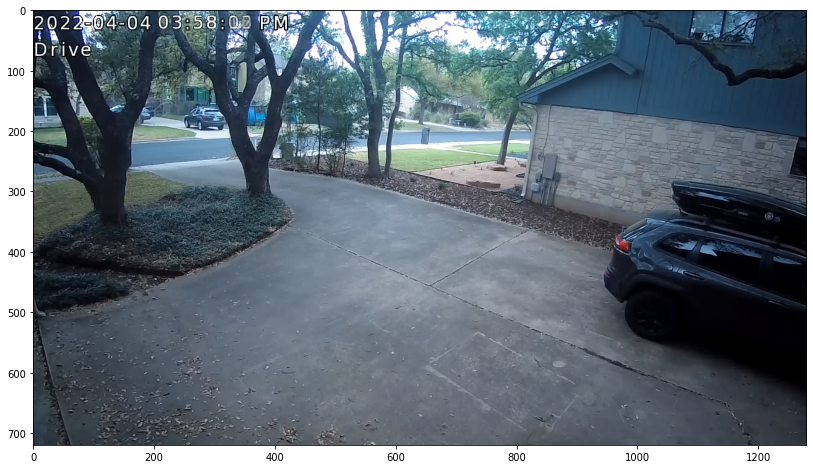

In [10]:
plt.rcParams['figure.figsize'] = [15, 8]
plt.imshow(total/np.max(total))


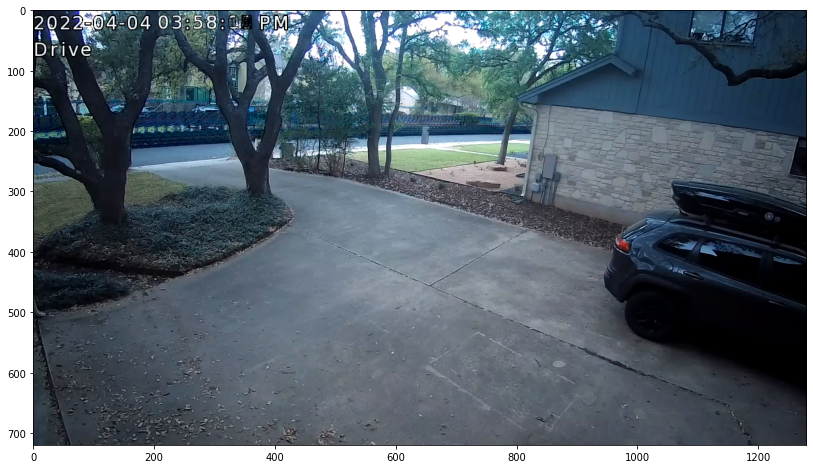

In [11]:
plt.imshow(small/np.max(small))

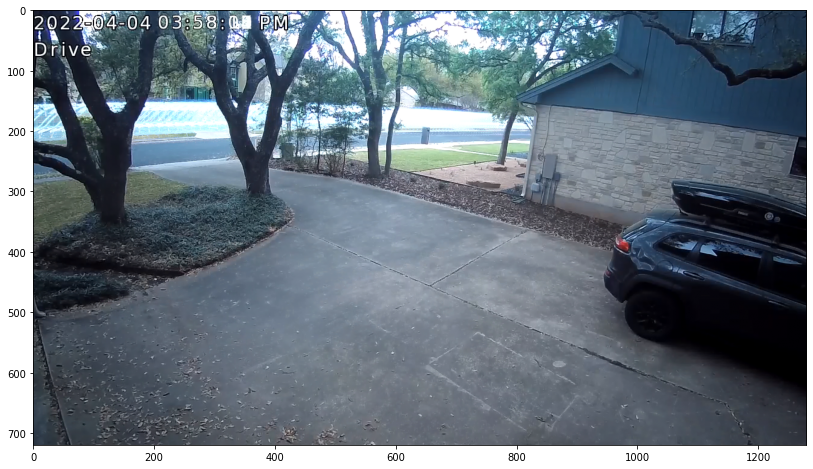

In [12]:
plt.imshow(big/np.max(big))

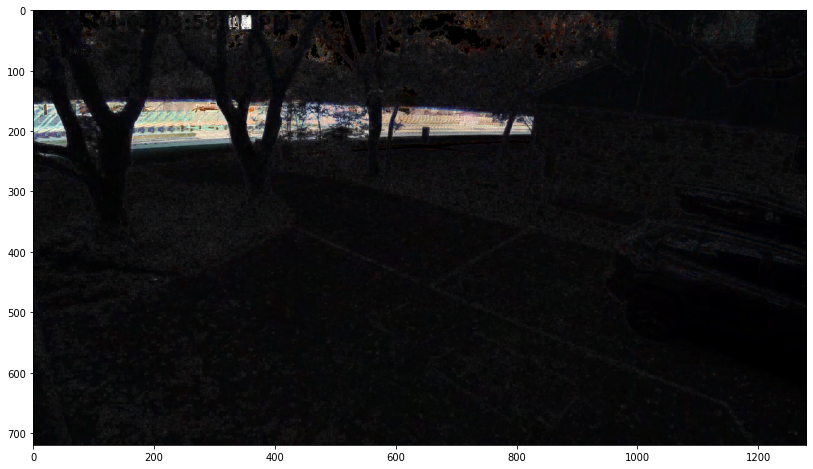

In [13]:
plt.imshow(diff/np.max(diff))

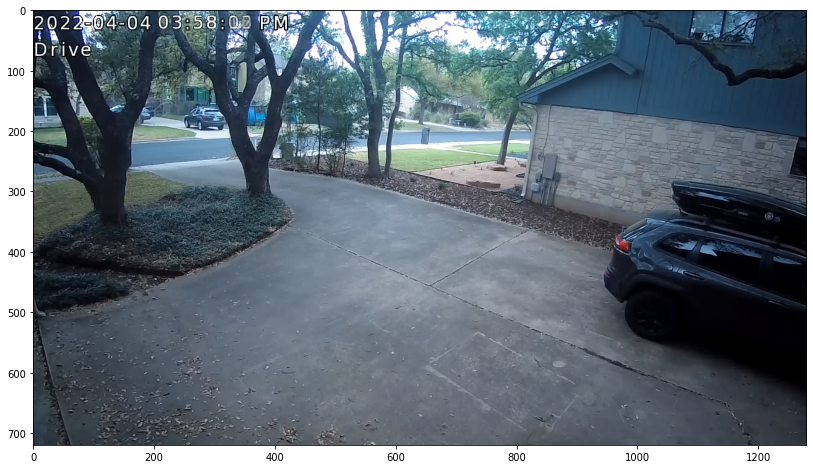

In [14]:
plt.imshow(avg/np.max(avg))

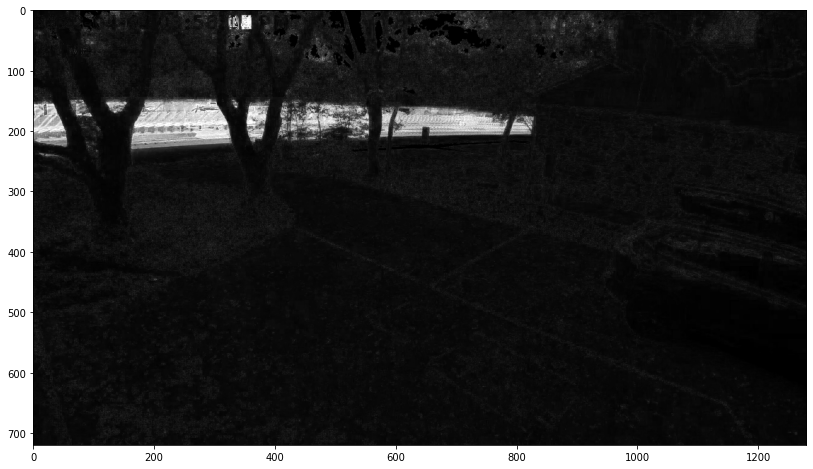

In [15]:
flat_diff = np.max(diff, axis=2)
plt.imshow(flat_diff/np.max(flat_diff), cmap='gray')

In [16]:
shadows = cv.imread('shadows.png')

In [17]:
def rescale(f):
    return ((f - np.min(f))/(np.max(f) - np.min(f)))

In [18]:
def L1(a,b):
    return np.sum(np.abs(a - b), axis=-1)

In [19]:
def color_angle(a,b):
    n = np.sqrt(np.sum( a * b,axis=2))
    d = np.linalg.norm(a,axis=2) * np.linalg.norm(b,axis=2)
    v = np.divide(n,d,out=np.zeros_like(d),where=d!=0)
    return np.arcsin(v)

In [28]:
@interact(frame=(0, num_frames))
def show_frame(frame=0):
    
    # p = color_angle( video[frame,:,:,:], shadows)
    p = video[frame,:,:,:] - diff
    
    plt.imshow(rescale(p), cmap='gray')

interactive(children=(IntSlider(value=0, description='frame', max=186), Output()), _dom_classes=('widget-inter…

In [21]:
p = color_angle( video[150,:,:,:], shadows)
np.shape(p)

(720, 1280)

In [22]:
a = shadows
b = video[150,:,:,:]
(np.shape(a), np.shape(b))

((720, 1280, 3), (720, 1280, 3))

In [23]:
d = np.linalg.norm(a,axis=2) * np.linalg.norm(b,axis=2)
np.shape(d)

(720, 1280)

In [24]:
c = np.sqrt(np.sum( a * b,axis=2))
np.shape(c)

(720, 1280)

In [25]:
v=   np.divide(c,d,out=np.zeros_like(d),where=d!=0)
np.shape(v)

(720, 1280)

In [26]:
r = np.arccos(v)
np.shape(r)

(720, 1280)

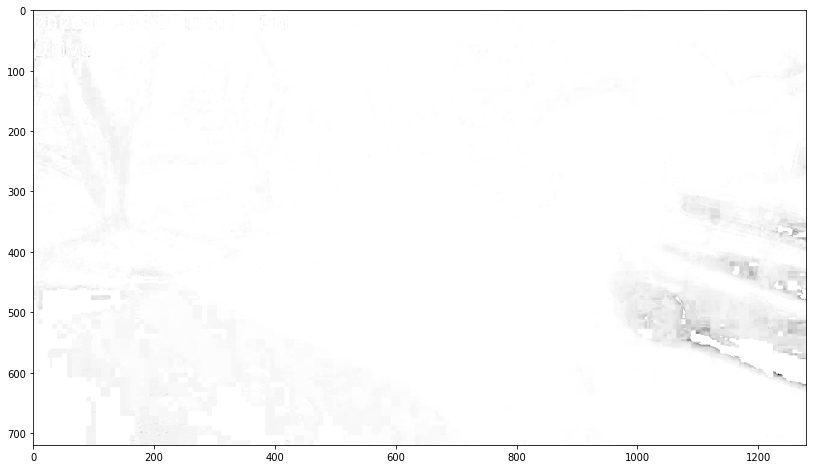

In [27]:
plt.imshow(rescale(r), cmap='gray')